In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Load data

In [2]:
importlist = [r'RawData\us-counties-2020.csv', r'RawData\us-counties-2021.csv', r'RawData\us-counties-2022.csv',
              r'PreprocessedData\mergedata.csv']
df_list = []
for importdata in importlist:
    df_list.append(pd.read_csv(importdata, header=0, encoding='utf-8'))
    
periods = [pd.Timestamp("2020-06-20"), pd.Timestamp("2020-12-20"), pd.Timestamp("2021-06-20"),
           pd.Timestamp("2021-12-20"), pd.Timestamp("2022-04-11")]

In [3]:
# complete feature matrix
allfeatures = df_list[3].copy()

# Random Forest model

In [4]:
# define target variable
coviddata = pd.concat([df_list[0], df_list[1], df_list[2]], axis=0)
coviddata['fips'] = coviddata['geoid'].apply(lambda x: int(x[-5:]))
coviddata['datetime'] = pd.to_datetime(coviddata['date'], format="%Y-%m-%d")

### aggregate over whole time period
targets = coviddata.groupby('fips').agg({'cases_avg_per_100k': 'mean', 'deaths_avg_per_100k': 'mean'})
renaming = {'cases_avg_per_100k': 'avgcases_all', 'deaths_avg_per_100k': 'avgdeaths_all'}
targets = targets.reset_index().rename(columns=renaming)

### aggregate per period
coviddata_periods = []
coviddata_periods_agg = []
for i in range(0, 5):
    if i == 0:
        coviddata_periods.append(coviddata[coviddata['datetime'] <= periods[i]])
    else:
        coviddata_periods.append(coviddata[(coviddata['datetime'] <= periods[i]) &
                                           (coviddata['datetime'] > periods[i - 1])])
    coviddata_periods_agg.append(coviddata_periods[i].groupby('fips').agg({'cases_avg_per_100k': 'mean',
                                                                           'deaths_avg_per_100k': 'mean'}))
    renaming = {'cases_avg_per_100k': f'avgcases_period{i + 1}', 'deaths_avg_per_100k': f'avgdeaths_period{i + 1}'}
    coviddata_periods_agg[i] = coviddata_periods_agg[i].reset_index().rename(columns=renaming)
    targets = targets.merge(coviddata_periods_agg[i], how='left', on='fips', indicator=False)

In [5]:
### binarize targets (hotspot or not)
contargets = [col for col in targets if col.startswith('avg')]
for col in contargets:
    newcol = str(col) + '_high'
    targets[newcol] = (targets[col] > targets[col].mean(skipna=True)).astype(int)
    targets.loc[targets[col].isna(), newcol] = np.nan

In [6]:
# define function to select data for random forest model
selfeatures_static = ['median_age_2019', 'housing_one_unit_structures_2019', 'households_speak_limited_english_2019',
                      'median_household_income_2019', 'median_individual_income_2019', 'unemployment_rate_2019',
                      'uninsured_2019', 'household_has_smartphone_2019', 'persons_per_household_2019', 'hs_grad_2019',
                      'bachelors_2019', 'Life expectancy', 'Airports', 'pop_density', 'PovertyRate',
                      'State population growth since 2010', 'Vote Democrat', 'Vote Republican', 'centrality score',
                      'betweenness score', 'pagerank score', 'Mean_temperature_perstate']


def constructXY(i, target, concatenate=False, keepid=False):
    i = i
    selfeatures_time = [f'Complete_{i}_rate', f'Booster_{i}_rate', f'Vaccination_{i}', f'Masks_{i}',
                        f'Close_schools_{i}', f'Mean_temperature_{i}']
    XY = allfeatures.merge(targets, how='left', on='fips', indicator=False)
    if not keepid:
        XY.drop(columns=[col for col in XY if (col not in selfeatures_static) and (col not in selfeatures_time)
                         and (col != target)], inplace=True)
    else:
        XY.drop(columns=[col for col in XY if (col not in selfeatures_static) and (col not in selfeatures_time)
                         and (col != target) and (col != 'fips')], inplace=True)
    XY = XY.dropna(axis=0, how='any').reset_index(drop=True)
    if not concatenate:
        X = XY.drop(columns=target)
        Y = XY[target].astype(int).copy()
        return X, Y
    else:
        return XY


In [9]:
# hypertuning random forest classifier using cv
X, Y = constructXY('all', 'avgcases_all_high')
rf = RandomForestClassifier(n_estimators=500, criterion="gini", max_features=1,
                                bootstrap=True, max_samples=0.8, oob_score=True, random_state=309)
param_grid = {
    'max_features': np.arange(1,10)
}
gridsearch = GridSearchCV(rf, param_grid=param_grid, verbose=1,cv=5,scoring="precision").fit(X,Y)
print('Final score is: ', gridsearch.score(X,Y))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Final score is:  1.0


In [7]:
shap.initjs()
rf = RandomForestClassifier(n_estimators=500, criterion="gini", max_features=gridsearch.best_params_['max_features'],
                            bootstrap=True, oob_score=True, random_state=303)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
0.9999999999999998


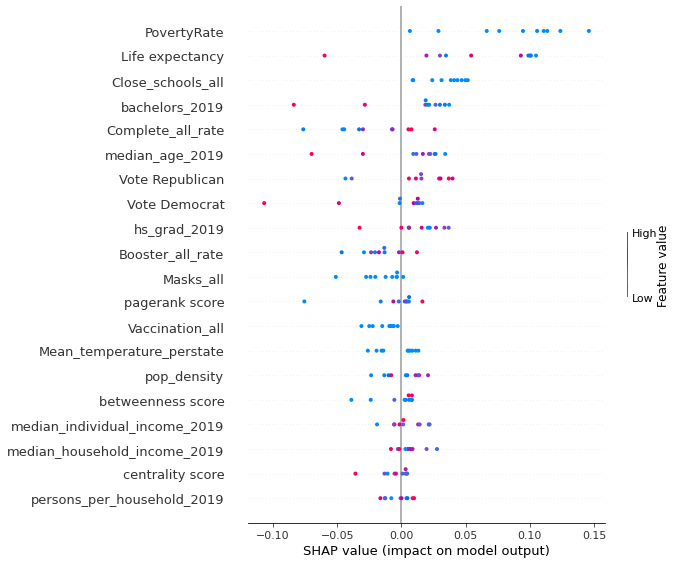

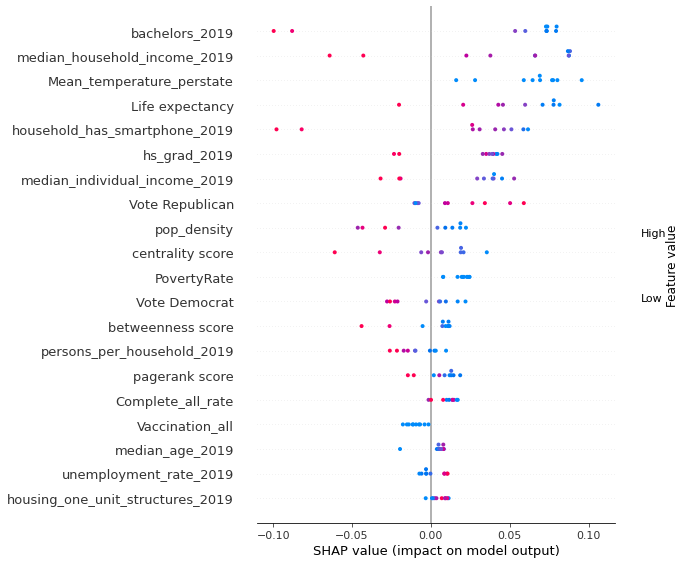

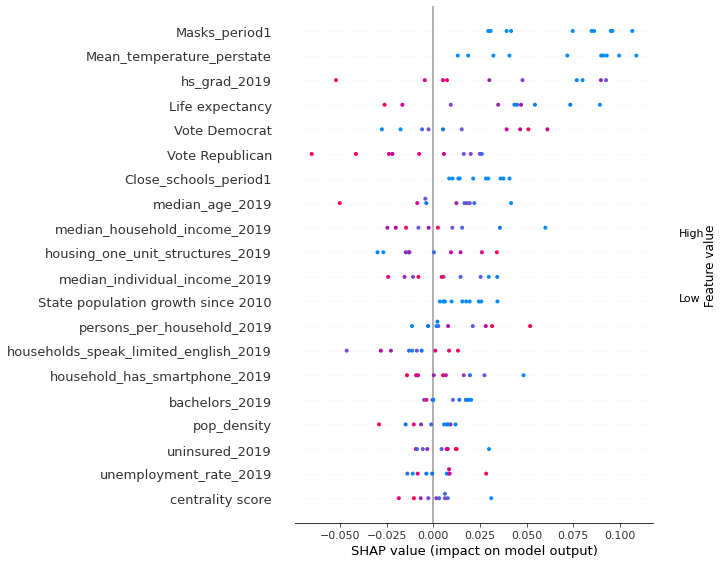

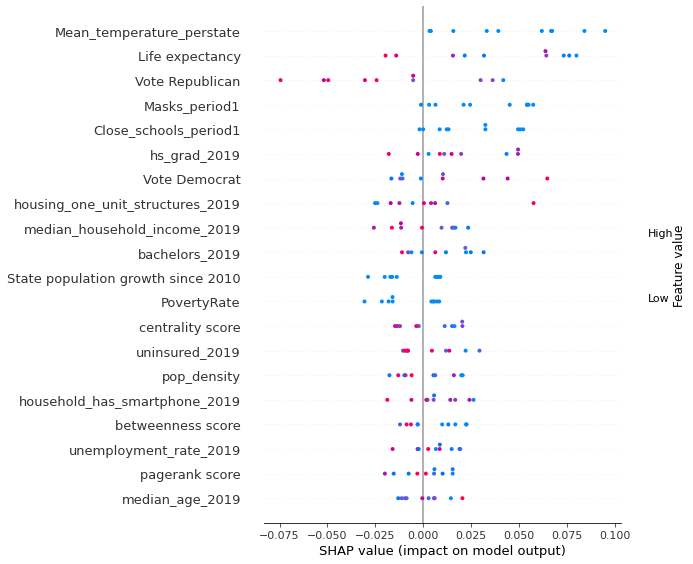

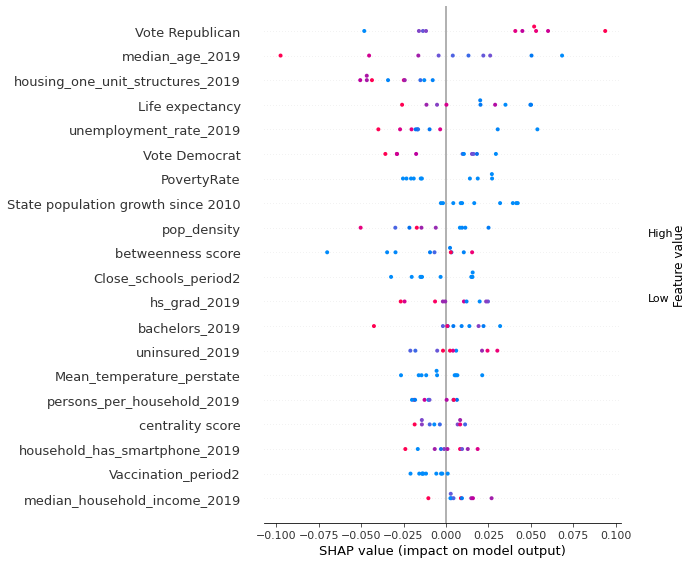

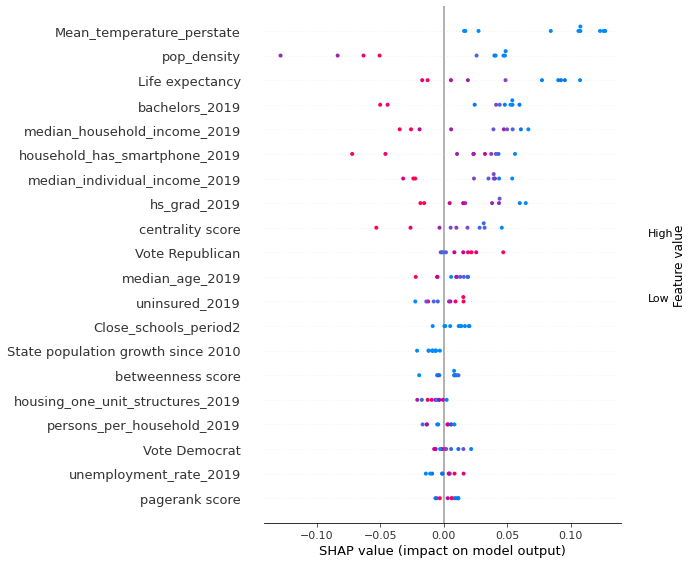

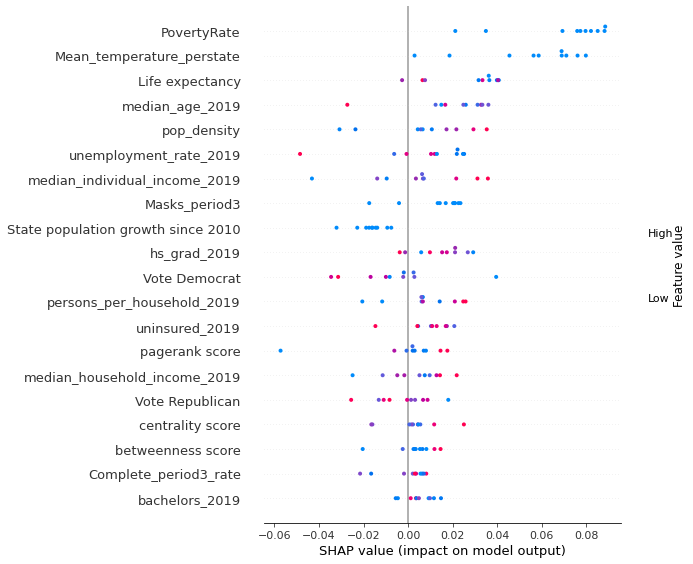

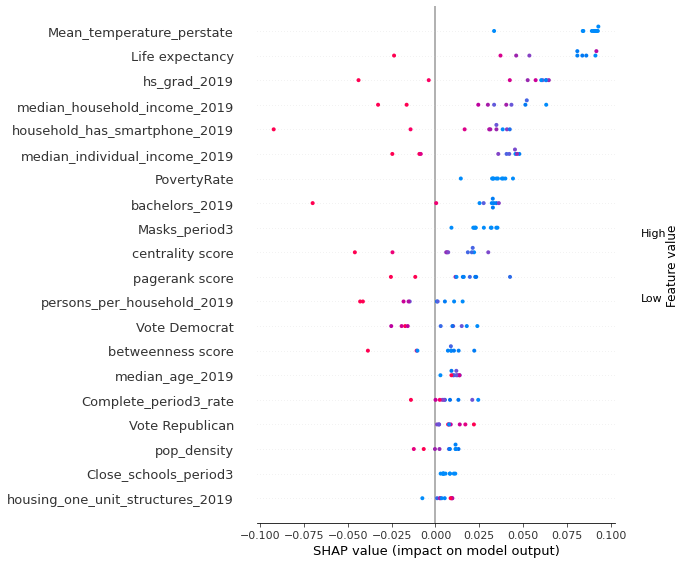

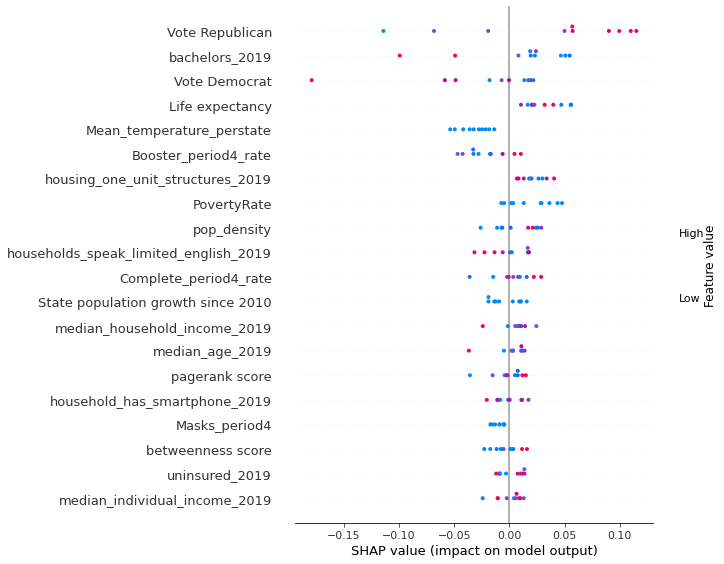

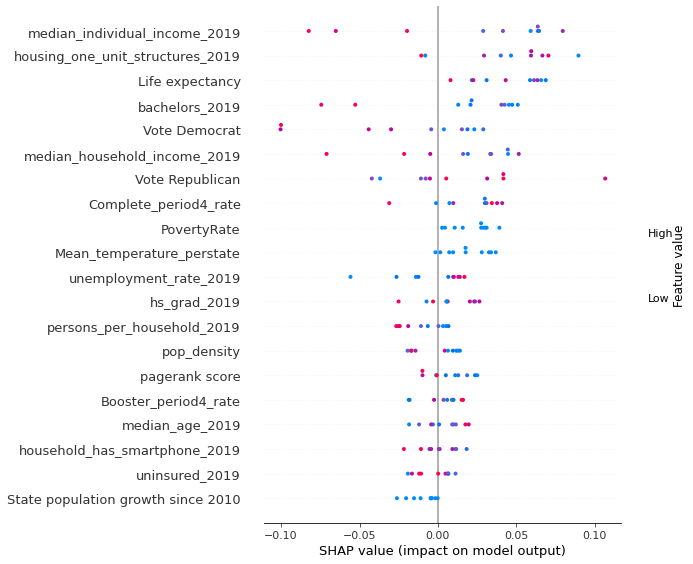

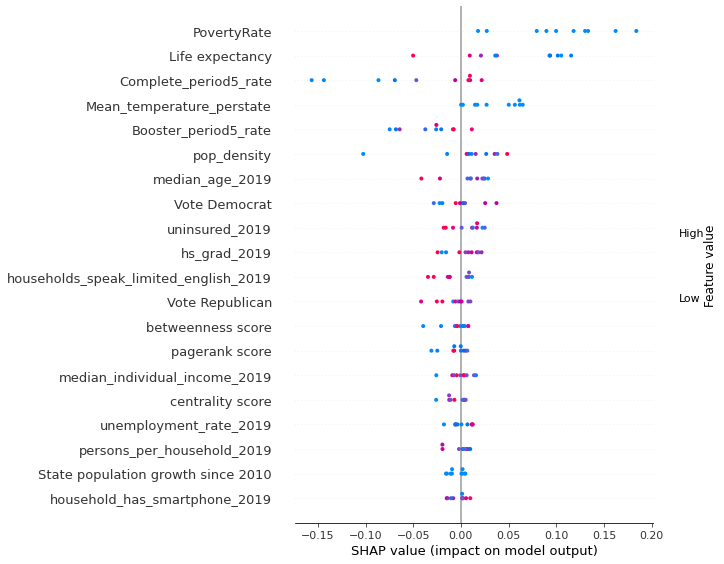

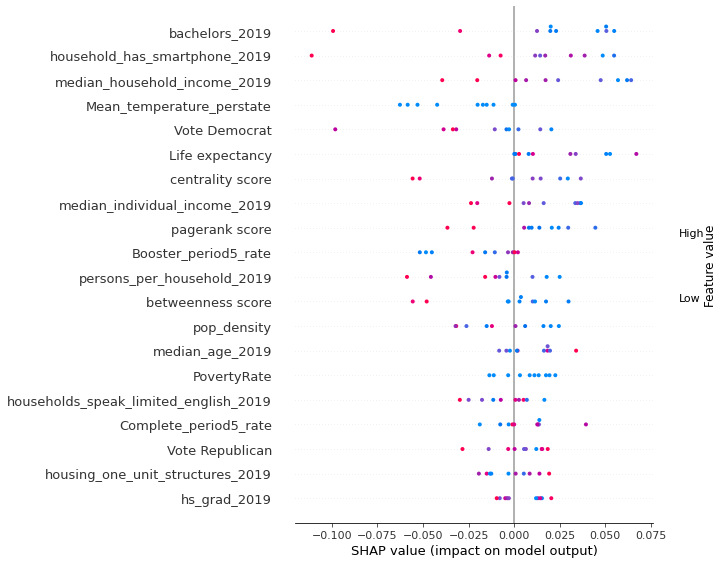

In [16]:
# fit random forest model for whole time period and per period
for i in ['all', 1, 2, 3, 4, 5]:
    if i=='all':
        period=i
    else:
        period = "period" + str(i)
    for target in [f'avgcases_{period}_high', f'avgdeaths_{period}_high']:
        X, Y = constructXY(period, target)
        
        rf.fit(X, Y)
        rf_Y = pd.DataFrame(rf.predict_proba(X), columns=['class 0', 'class 1'])
        
        print(roc_auc_score(Y, rf_Y['class 1']))
        print(average_precision_score(Y, rf_Y['class 1']))
        
        explainer = shap.TreeExplainer(rf)
        shap_values = explainer.shap_values(X)
        plt.figure()
        fig=shap.summary_plot(shap_values[1], X, feature_names=X.columns,show=False)
        plt.savefig(os.path.join('Figures', f'{target}.png'), bbox_inches='tight')

# Fit prediction model

Fit a prediction model to predict he period-5 hotspots based on first 4 periods.

In [17]:
### prepare training data (first 4 periods)
df_train = pd.DataFrame()
for i in range(1, 5):
    period = "period" + str(i)
    period_prior = "period" + str(i - 1)
    XY = constructXY(period, f'avgcases_{period}_high', concatenate=True, keepid=True)
    
    if i == 1:
        XY[f'avgcases_{period_prior}'] = 0
        XY[f'avgdeaths_{period_prior}'] = 0
    else:
        XY = XY.merge(targets[[f'avgcases_{period_prior}', f'avgdeaths_{period_prior}', 'fips']], how='left',
                      on='fips', indicator=False)
        
    renaming = {f'Vaccination_{period}': 'Vaccination', f'Masks_{period}': 'Masks',
                f'Close_schools_{period}': 'Close_schools', f'Complete_{period}_rate': 'Complete_rate',
                f'Booster_{period}_rate': 'Booster_rate', f'Mean_temperature_{period}': 'Mean_temperature_period',
                f'avgcases_{period}_high': 'avgcases_high', f'avgdeaths_{period}_high': 'avgdeaths_high',
                f'avgcases_{period_prior}': 'avgcases_prior', f'avgdeaths_{period_prior}': 'avgdeaths_prior'}
    XY = XY.rename(columns=renaming).dropna(axis=0, how='any').reset_index(drop=True)
    df_train = pd.concat([df_train, XY], axis=0)

X_train = df_train.drop(columns=['avgcases_high', 'fips']).copy()
Y_train = df_train['avgcases_high'].copy()

In [18]:
### prepare test data (period 5)
X_test, Y_test = constructXY('period5', 'avgcases_period5_high', keepid=True)
X_test = X_test.merge(targets[['avgcases_period4', 'avgdeaths_period4', 'fips']], how='left',
                      on='fips', indicator=False)
renaming = {'Vaccination_period5': 'Vaccination', 'Masks_period5': 'Masks', 'Close_schools_period5': 'Close_schools',
            'Complete_period5_rate': 'Complete_rate', 'Booster_period5_rate': 'Booster_rate',
            'Mean_temperature_period5': 'Mean_temperature_period',
            'avgcases_period4': 'avgcases_prior', 'avgdeaths_period4': 'avgdeaths_prior'}
X_test.rename(columns=renaming, inplace=True)
Y_test = Y_test.to_frame(name='true')
Y_test['fips'] = X_test.pop('fips')


In [19]:
### train model
rf.fit(X_train, Y_train)

### test model
rf_Y = pd.DataFrame(rf.predict_proba(X_test), columns=['class 0', 'class 1'])
rf_Y['true'] = Y_test['true']
rf_Y['fips'] = Y_test['fips']

print(roc_auc_score(rf_Y['true'], rf_Y['class 1']))
print(average_precision_score(rf_Y['true'], rf_Y['class 1']))

0.6340052892697527
0.6525947914186612


In [20]:
### categorize predictions (true/ false positive/ negative) and export results
def predictionCat(rowtrue, rowpred):
    med = rf_Y['class 1'].median()
    if rowtrue == 1 and rowpred > med:
        return 'True positive'
    elif rowtrue == 0 and rowpred > med:
        return 'False positive'
    elif rowtrue == 1 and rowpred <= med:
        return 'False negative'
    elif rowtrue == 0 and rowpred <= med:
        return 'True negative'


rf_Y['category'] = rf_Y.apply(lambda x: predictionCat(x['true'], x['class 1']), axis=1)
rf_Y.to_excel(os.path.join('PreprocessedData', 'period5_prediction_results.xlsx'), header=True, index=False)